In [39]:
%matplotlib inline
import numpy as np
import scipy.signal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as path

In [30]:
# functions to parse file, check data formatting and create dataframe

def parse_csv(data_file):
    lines = []
    samp_ind = 0
    m = None
    with open(data_file, 'r') as fh:
        header_found = False
        for i, line in enumerate(fh):
            # skip comments
            if line[0] == '%':
                continue
            # parse lines
            tokens = line.strip().split(",")
            if not(header_found):
                header_found = True
                assert len(tokens) == 1
                n = float(tokens[0])
                assert float(int(n)) == n
                n = int(n)
            else:
                assert int(tokens[0]) == samp_ind
                samp_ind = (samp_ind + 1) % 256
                if m is None:
                    m = len(tokens)-1
                try:
                    assert len(tokens)-1 == m
                    lines.append([float(e) for e in tokens[1:]])
                except (ValueError, AssertionError):
                    # often the last line if it was interrupted?
                    print("Failed to parse: {}".format(line))
    return lines, n, m  # not sure what n is


def load_df(data_file, trigger_ind=17):
    lines, _, nb_fields = parse_csv(data_file)
    assert nb_fields == 19
    df = {'channel': [], 'activity': [], 'index': []}
    for i, row in enumerate(lines):
        for ch_ind in range(16):
            df['activity'].append(row[ch_ind])
            df['channel'].append('channel {}'.format(ch_ind))
            df['index'].append(i)
        df['activity'].append(row[trigger_ind])
        df['channel'].append('trigger')
        df['index'].append(i)
    df = pd.DataFrame(df)
    return df

def load_raw_recordings(data_files, fs=250):
    dfs = {f: load_df(data_files[f]) for f in data_files}
    for f in dfs:
        dfs[f]['participant'] = f
    raw_eeg = pd.concat(dfs)
    SCALE_FACTOR_EEG = (4500000)/24/(2**23-1) #uV/count
    #SCALE_FACTOR_AUX = 0.002 / (2**4)
    raw_eeg['activity'] = SCALE_FACTOR_EEG * raw_eeg['activity']
    raw_eeg['time'] = raw_eeg['index']/float(fs)
    return raw_eeg

In [127]:
# Whole session data checks and pre-processing

def plot_subset(raw_eeg, channels, time_range, stride=1, height=1, aspect=5,
                act_col='activity'):
    chans = ['channel {}'.format(ch) for ch in channels]
    subset = raw_eeg[([ch in chans for ch in raw_eeg['channel']]) &
                     (raw_eeg['time'] >= time_range[0]) &
                     (raw_eeg['time'] <= time_range[1]) &
                     ([ind % stride == 0 for ind in raw_eeg['index']])]
    g = sns.relplot(data=subset, col='participant', row='channel', y=act_col, x='time',
                    facet_kws={'sharey': False}, kind='line', height=height, aspect=aspect)
    g.set_axis_labels('time (s)', 'EEG activity (uV)')
    return g


def get_Butterworth_filter(cutoff, N, fs=250, plot=False):
    f_Nyq = fs/2.
    Wn = cutoff/f_Nyq
    b, a = scipy.signal.butter(N, Wn, btype='high')
    if plot:
        # plot frequency response
        w, h = scipy.signal.freqz(b, a, worN=8192)
        f = w/(2*np.pi)*f_Nyq
        plt.figure()
        plt.plot(f, 20 * np.log10(abs(h)))
        plt.xscale('log')
        plt.title('Butterworth filter frequency response')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Amplitude [dB]')
        plt.margins(0, 0.1)
        plt.grid(which='both', axis='both')
        plt.axvline(cutoff, color='green') # cutoff frequency
        # plot impulse response
        system = scipy.signal.dlti(b, a)
        t, y = scipy.signal.dimpulse(system, n=500)
        plt.figure()
        plt.step(t/float(fs), np.squeeze(y))
        plt.grid()
        plt.title('Butterworth filter impulse response')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
    return b, a


def apply_filter(b, a, df, fs=250):
    times = np.array(df['time'])
    order = np.argsort(times)
    activity = np.array(df['activity'])[order]
    # get initial filter conditions so has to avoid spurious transients
    zi = activity[0]*scipy.signal.lfilter_zi(b, a)
    filtered_act, zf = scipy.signal.lfilter(b, a, activity, zi=zi)
    filtered_act[order] = filtered_act
    df['activity'] = filtered_act
    return df


def filter_recordings(recordings, cutoff=1, N=3, fs=250, plot=True):
    # Filter with high-pass Butterworth filter with cut-off frequency at 1 Hz (filter with maximally flat passband)
    # See e.g. https://sapienlabs.org/pitfalls-of-filtering-the-eeg-signal/
    # use lfilter to make sure filtering is causal, with appropriate initial conditions to avoid initial transient
    # cutoff in Hz, (-3dB point)
    # N Butterworth filter order, could use scipy.signal.buttord to select it
    b, a = get_Butterworth_filter(cutoff=cutoff, N=N, fs=fs, plot=plot)
    filtered_recordings = recordings.groupby(['channel', 'participant']).apply(lambda df: apply_filter(b, a, df, fs=fs))
    return filtered_recordings

In [139]:
# Trigger related functions

def parse_triggers(df):
    off = True
    trigger_inds = []
    trig_df = df[df['channel'] == 'trigger']
    inds = np.array(trig_df['index'])
    order = np.argsort(inds)
    assert np.array_equal(inds[order], np.arange(len(order)))
    triggers = np.array(trig_df['activity'])[order]
    for i, val in enumerate(triggers):
        if off and val > 0:
            off = False
            trigger_inds.append(i)
        elif not(off) and val == 0:
            off = True
    return np.array(trigger_inds)


def check_triggers(df, fs=250, plot=True):
    trigger_inds = parse_triggers(df)
    trigger_ISIs = trigger_inds[1:]-trigger_inds[:-1]
    if plot:
        plt.figure()
        h = plt.hist(trigger_ISIs)
    return min(trigger_ISIs/float(fs)), max(trigger_ISIs/float(fs))

In [154]:
# ERP stuff

def collect_ERPs(raw_eeg, filtered_eeg, delta=1.5, fs=250, verbose=0):
    # collect median ERP +/- delta seconds around trigger for each channel of each participant
    # raw_eeg is only used for triggers here
    # delta in seconds, fs in Hz
    nb_samp = int(delta*fs)
    dfs = []
    for part, df_part in filtered_eeg.groupby('participant'):
        if verbose:
            print("Collecting ERPs for participant {}".format(part))
        triggers = parse_triggers(raw_eeg[raw_eeg['participant'] == part])
        for chan, df in df_part.groupby('channel'):
            if verbose > 1:
                print(chan)
            for i, ind in enumerate(triggers):
                df_erp = df[(df['index'] >= ind-nb_samp) & (df['index'] <= ind+nb_samp)]
                df_erp = df_erp.copy()
                df_erp['epoch'] = i
                df_erp['time'] = np.arange(-nb_samp, nb_samp+1)/float(fs)
                dfs.append(df_erp)
    return pd.concat(dfs)


def plot_median_ERP(df_ERP, participant=None, height=2, aspect=10, sharey=True):
    if not(participant is None):
        df = df_ERP[df_ERP['participant'] == participant]
    else:
        df = df_ERP 
    median_ERP = df.groupby(['time', 'channel', 'participant'], as_index=False).median()
    g = sns.relplot(data=median_ERP, col='participant', row='channel', y='activity', x='time',
                        facet_kws={'sharey': sharey}, kind='line', height=height, aspect=aspect)
    g.set_axis_labels('time (s)', 'EEG activity (uV)')
    for ax in g.axes.flatten():
        ax.grid()
    t = g.fig.suptitle("Median ERP")

# Main

In [33]:
# params
root = '/Users/admin/Documents/PhD/Data/audmem/EEG_recordings'

data_files = {'Thomas': 'OPBCI_45_test_Thomas.csv', 'Sweat': 'OPBCI_2F_test_sweat.csv'}
data_files = {participant: path.join(root, data_files[participant]) for participant in data_files}

# load data
raw_eeg = load_raw_recordings(data_files)

Failed to parse: 232,38749.9,39829.824,22885.123,



## Checks on raw data + pre-processing

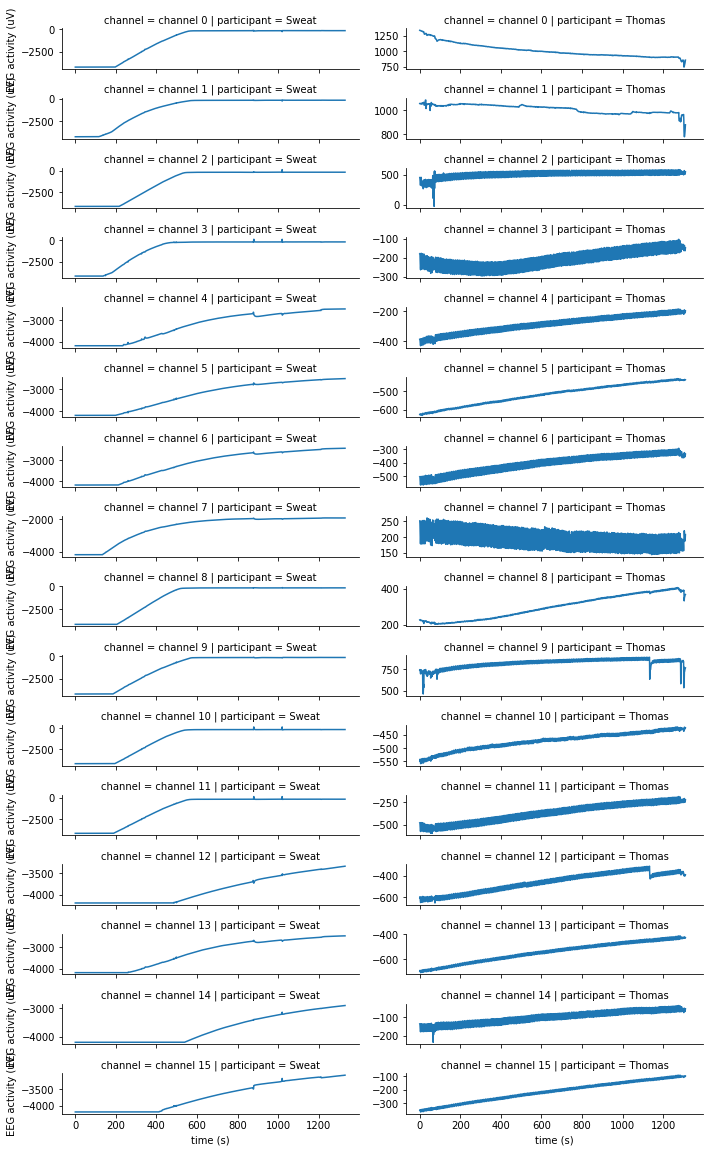

In [129]:
# look at session-wide slow drift
channels = np.arange(16)
time_range = [0, np.inf]  # in seconds

# only plot every stride sample (1 for 4 ms stride if fs=250Hz), useful to avoid too big plots
# could do low pass filtering for more principled approach
stride = 250  # every second
g = plot_subset(raw_eeg, channels, time_range, stride=stride)

/Users/admin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log10


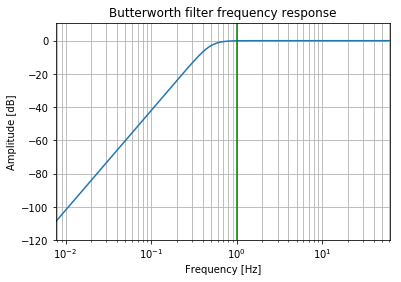

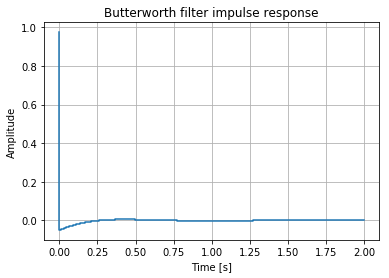

In [132]:
filtered_eeg = filter_recordings(raw_eeg)

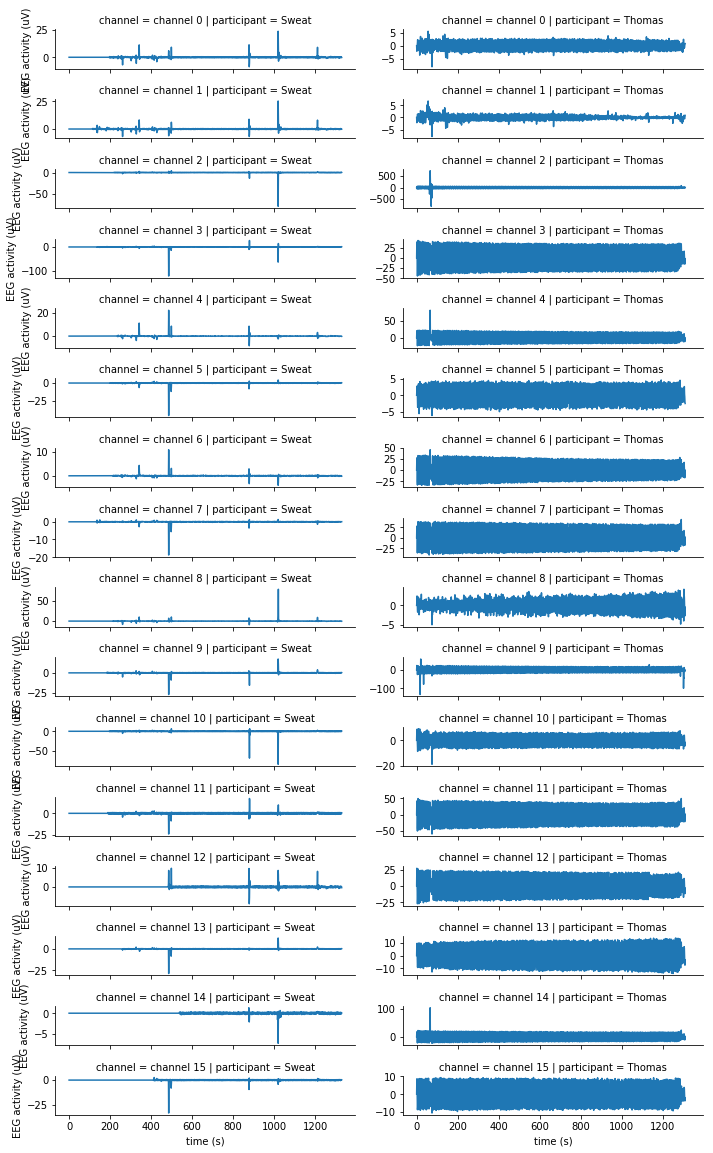

In [133]:
# look at session-wide slow drift after filtering
channels = np.arange(16)
time_range = [0, np.inf]  # in seconds

# only plot every stride sample (1 for 4 ms stride if fs=250Hz), useful to avoid too big plots
# could do low pass filtering for more principled approach
stride = 250  # every second
g = plot_subset(filtered_eeg, channels, time_range, stride=stride)

332729
Participant Sweat triggers' ISI range: 0.452-0.912 seconds
327656
Participant Thomas triggers' ISI range: 0.448-0.752 seconds


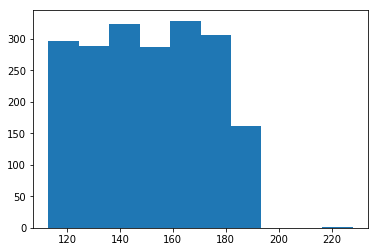

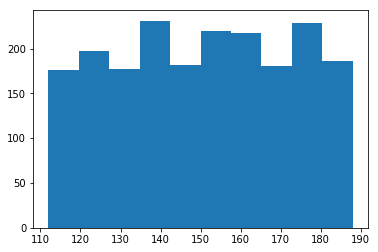

In [138]:
# Check triggers are detected correctly
# Do it on raw_eeg, as trigger channel is filtered in filtered_eeg
# Supposed to be 600 +/- 150 ms ISI with current test stimulus
# one outlier for sweater ...
for part, df in raw_eeg.groupby('participant'):
    mi, ma = check_triggers(df)
    print("Participant {} triggers' ISI range: {}-{} seconds".format(part, mi, ma))

## ERP analyses

In [147]:
df_ERP = collect_ERPs(raw_eeg, filtered_eeg, delta=.5, verbose=1)

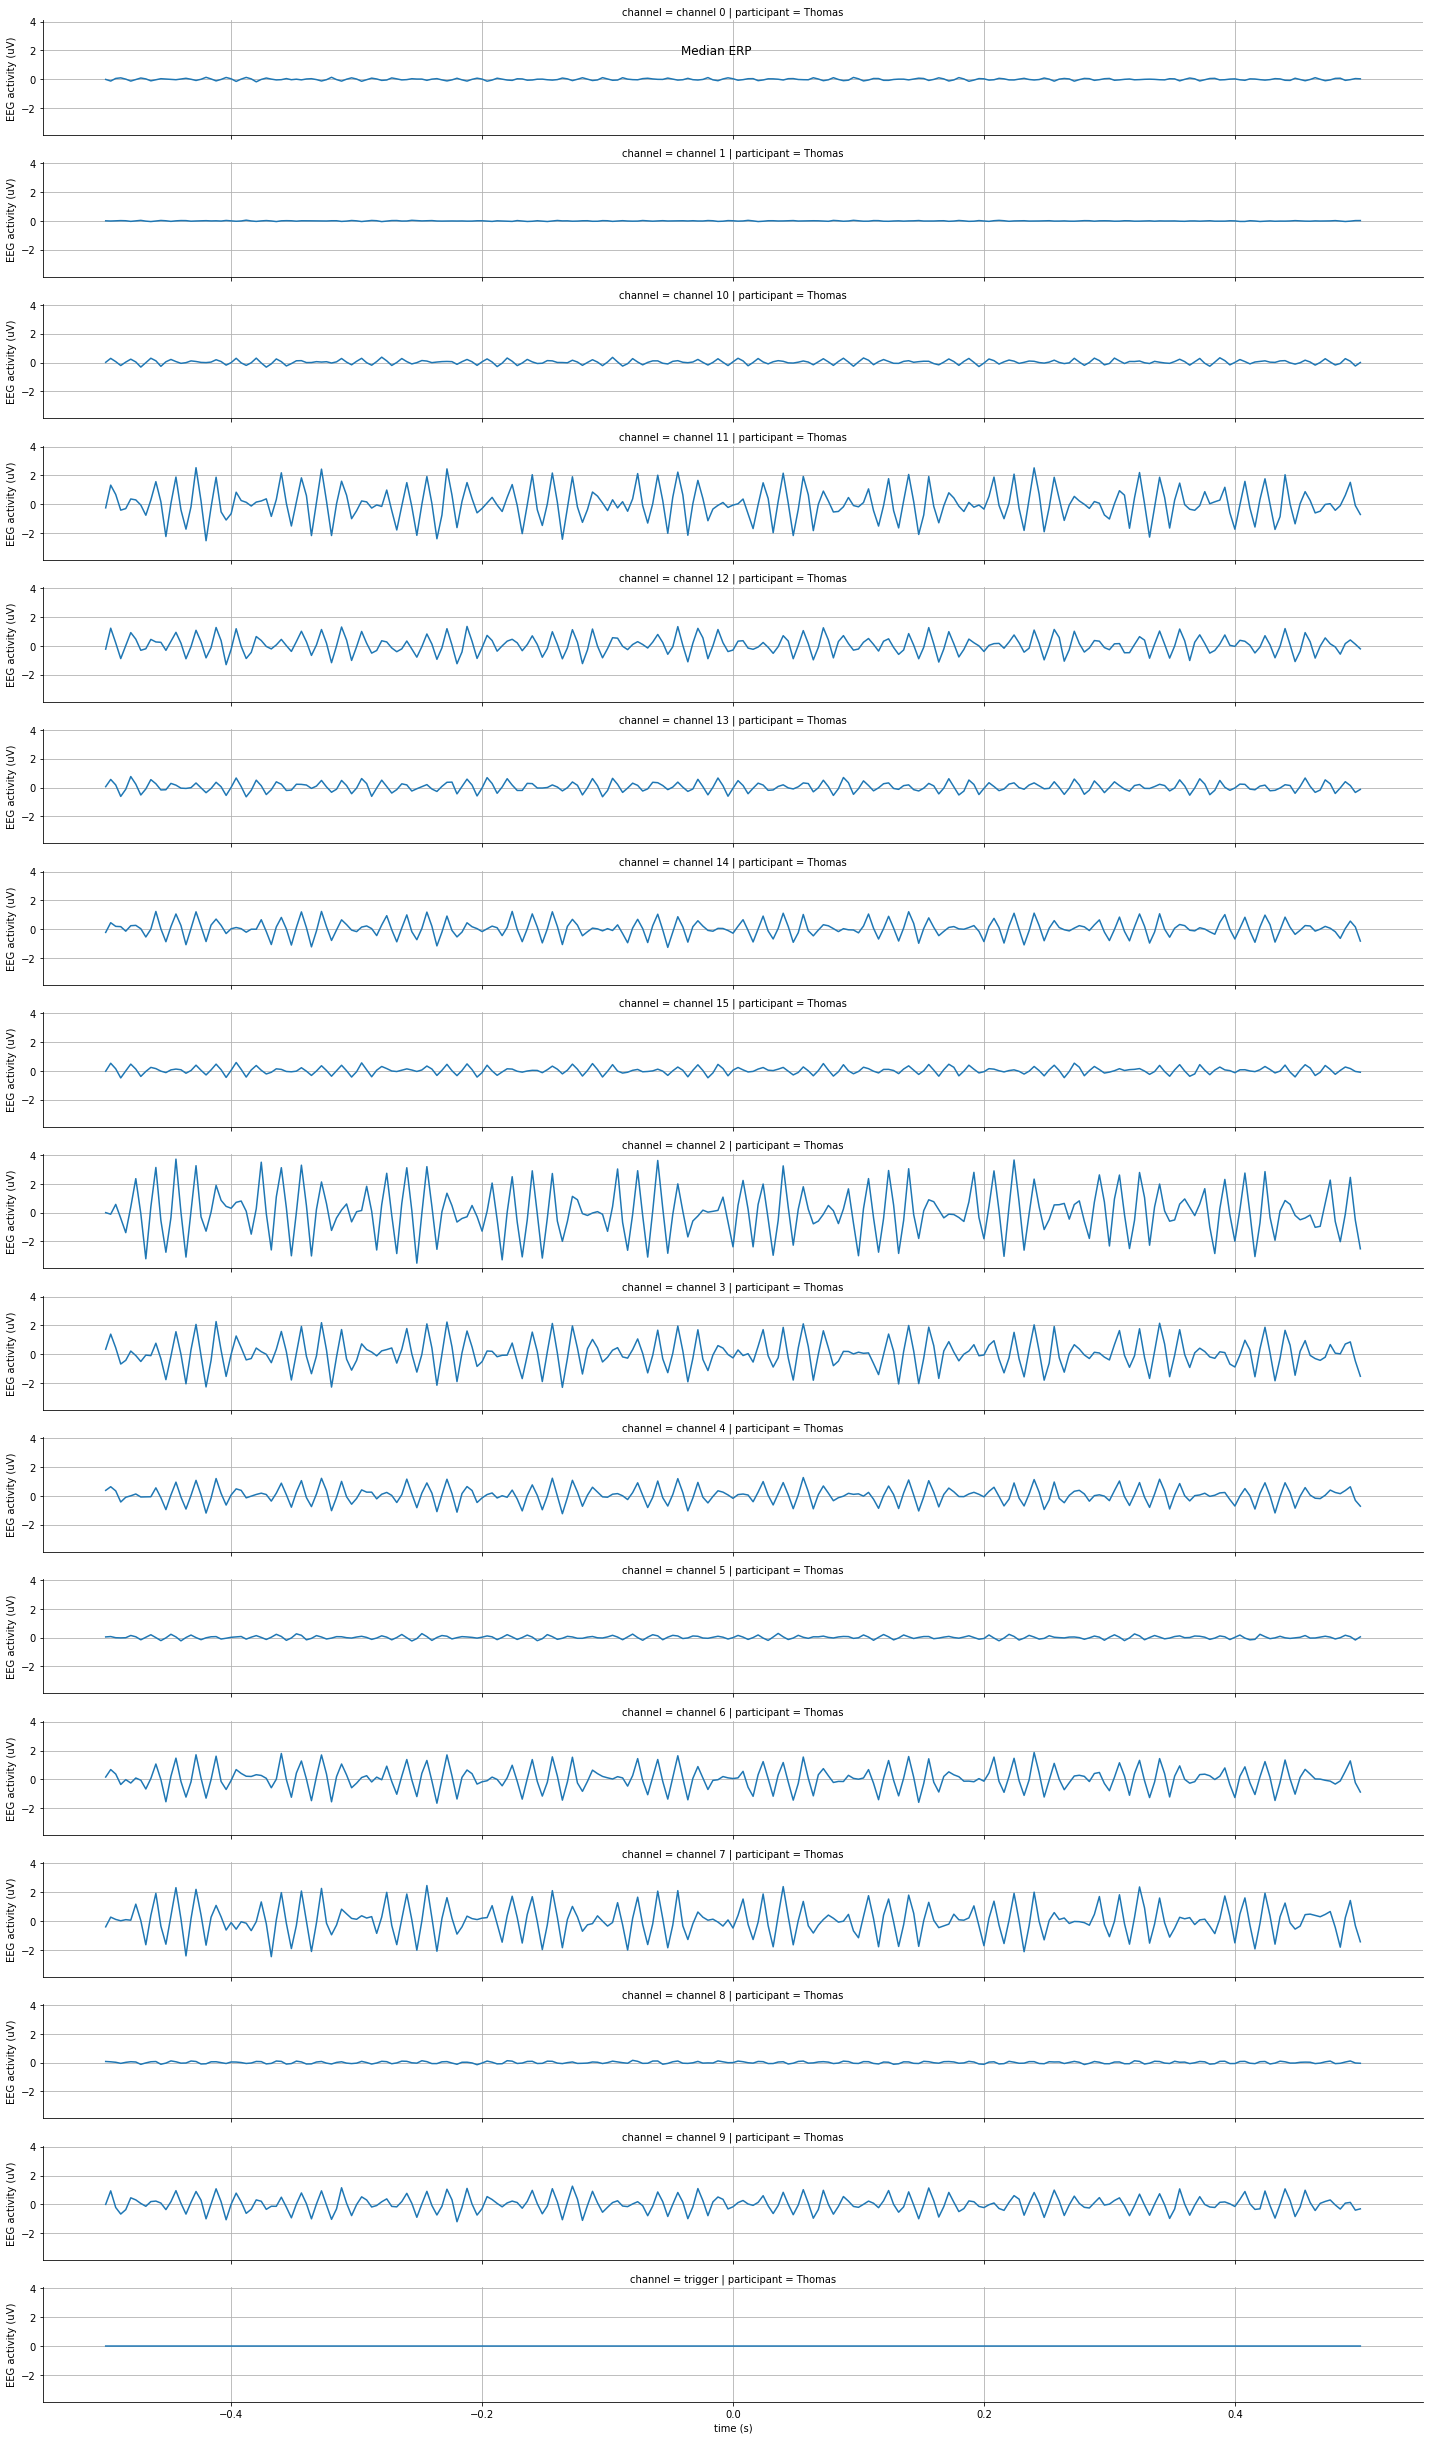

In [156]:
plot_median_ERP(df_ERP, participant='Thomas', height=2, aspect=10)

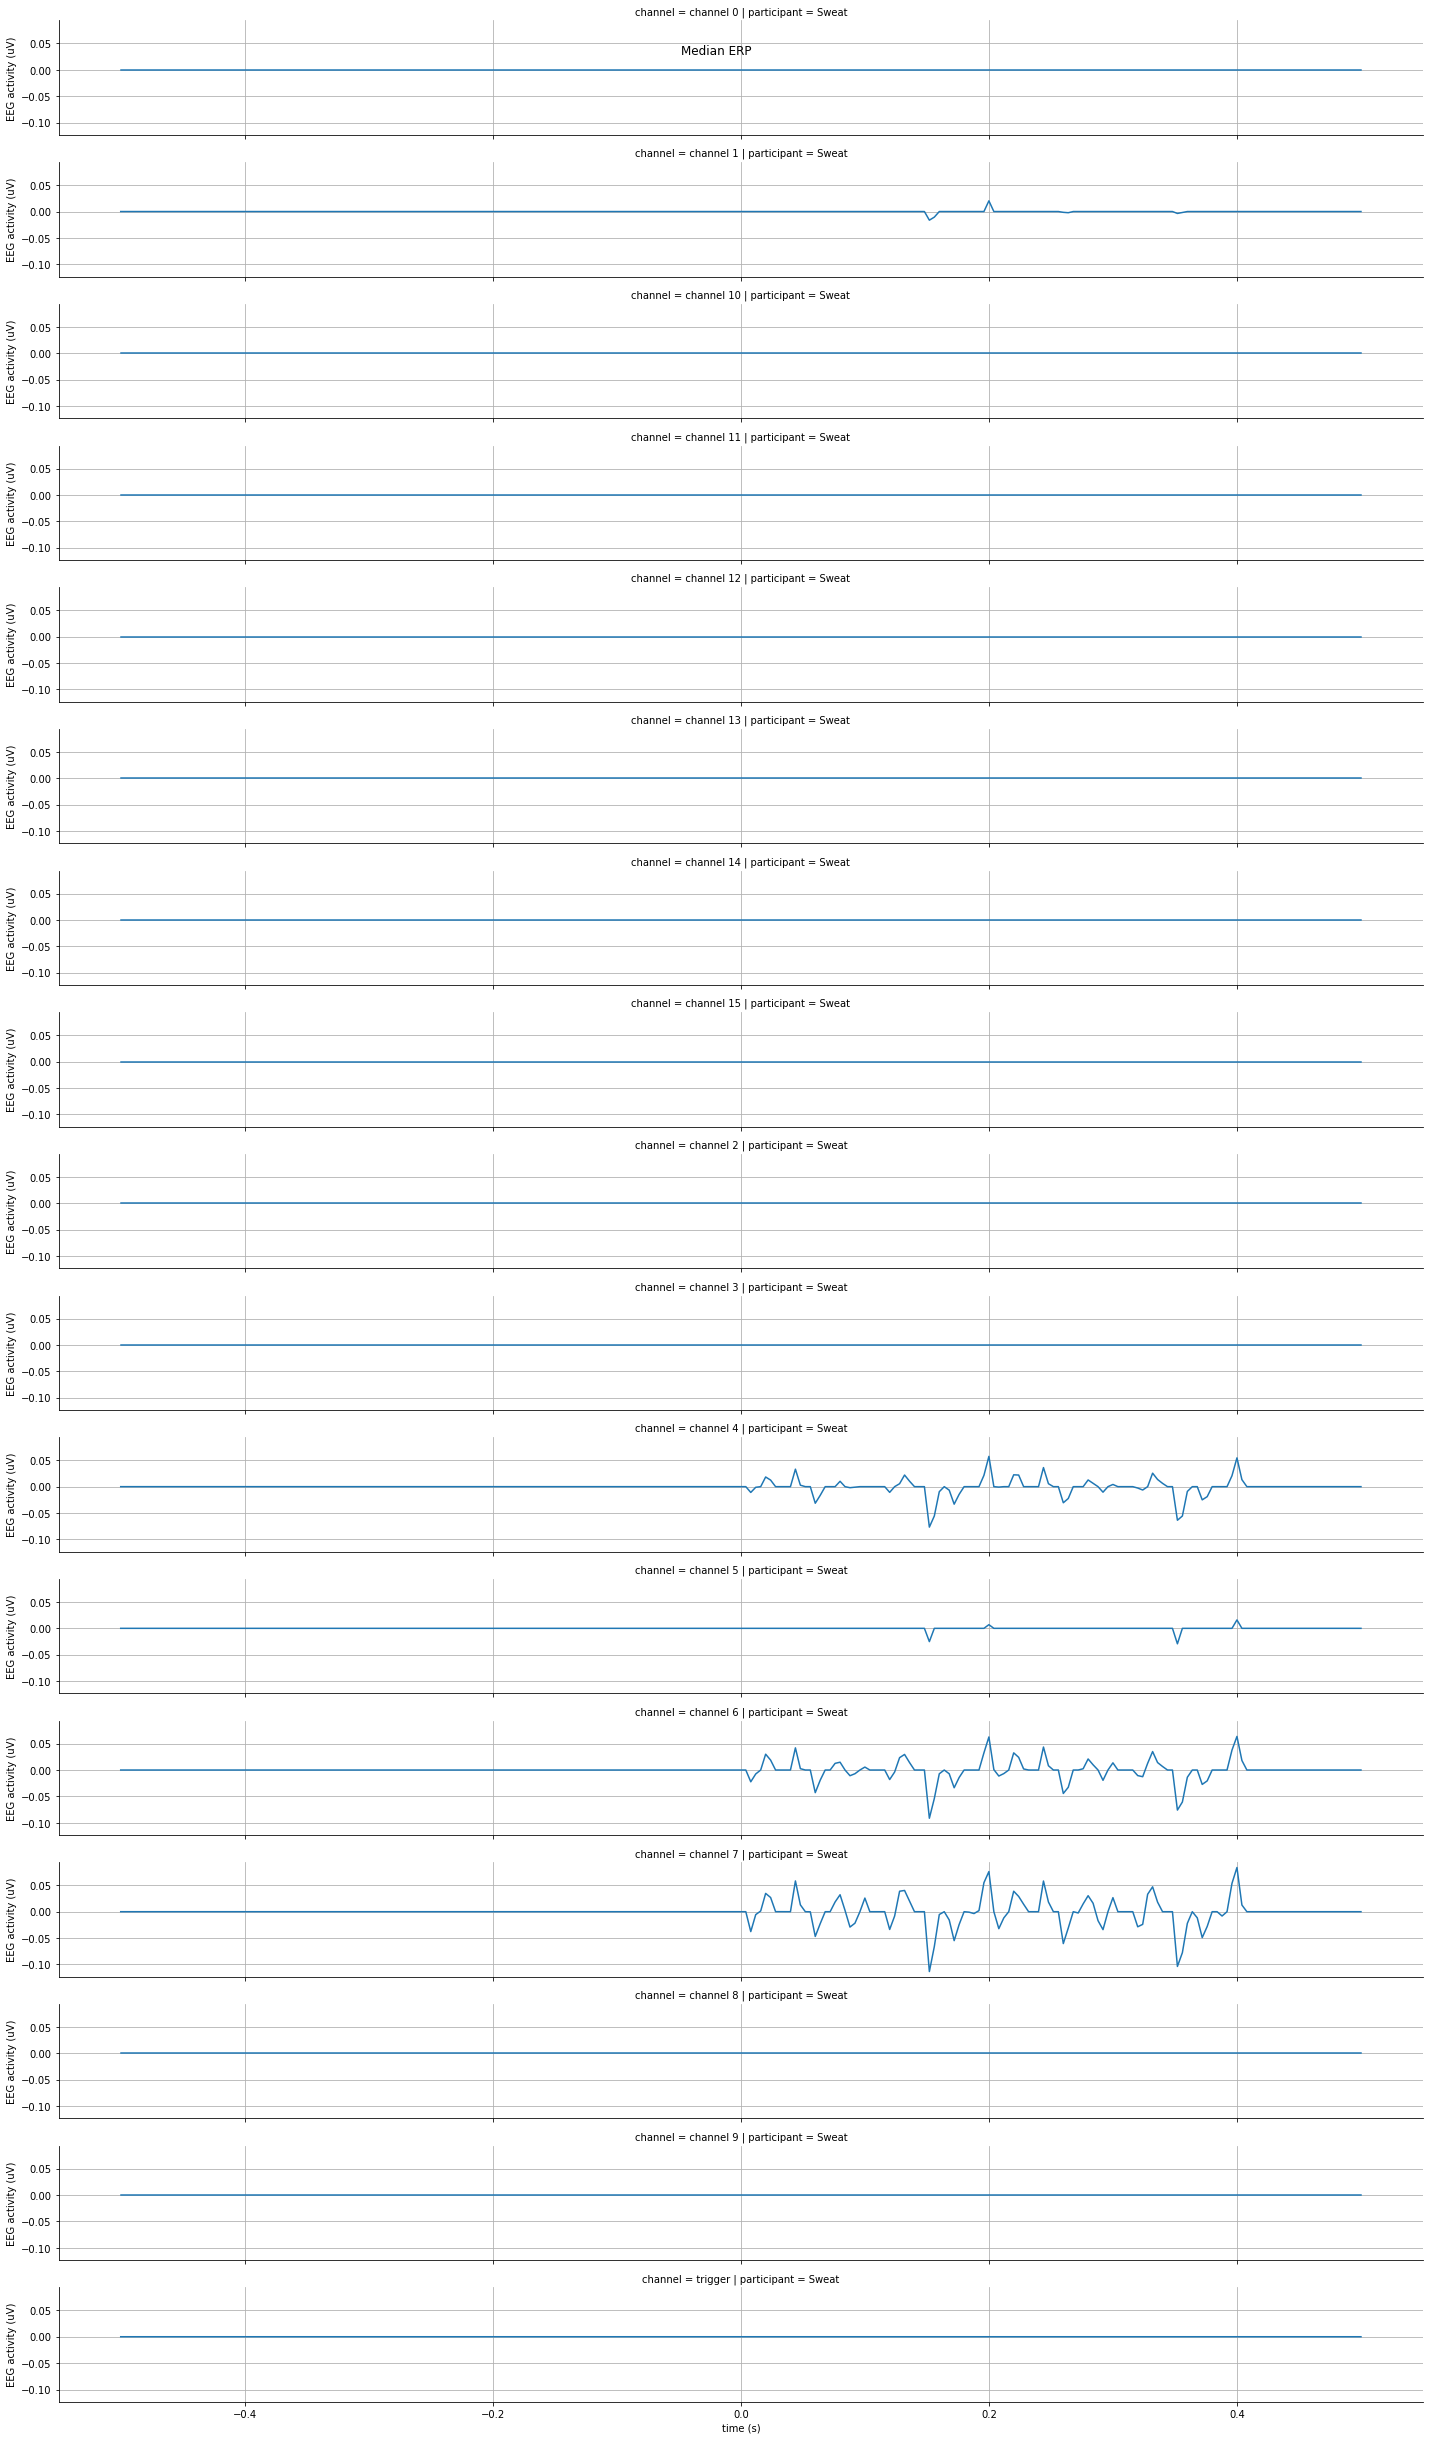

In [155]:
plot_median_ERP(df_ERP, participant='Sweat', height=2, aspect=10)

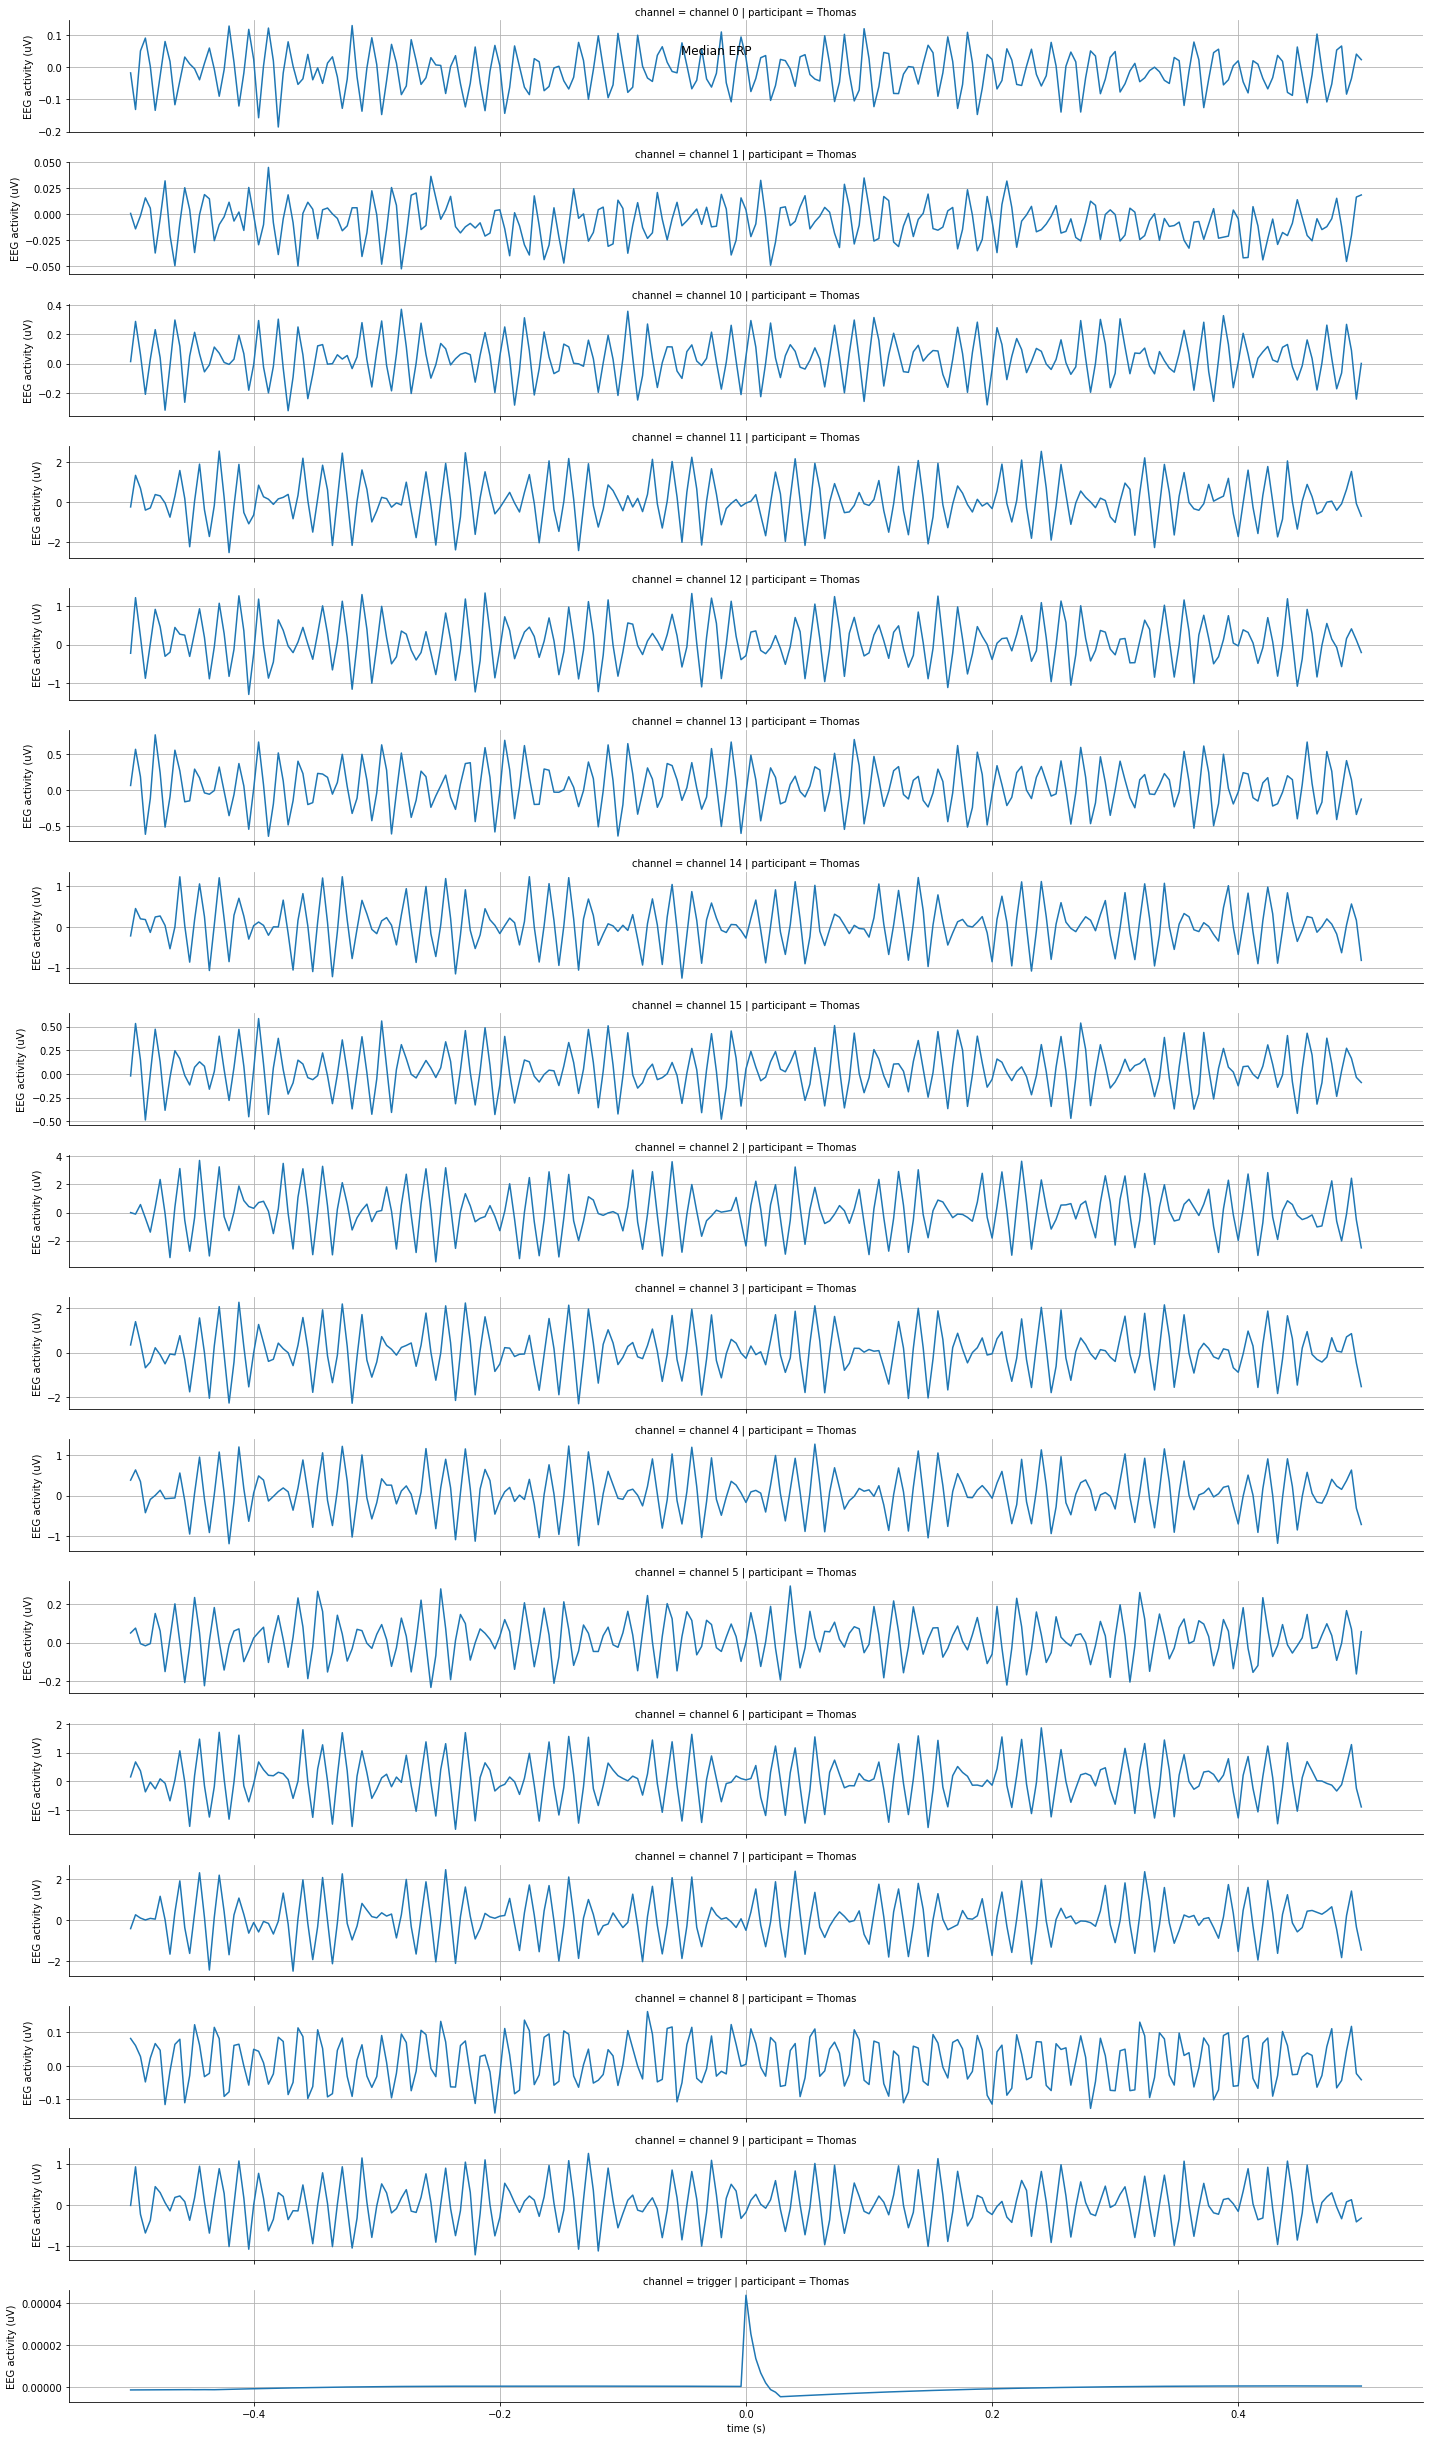

In [157]:
# Resultats avec y-axis non partage
plot_median_ERP(df_ERP, participant='Thomas', height=2, aspect=10, sharey=False)

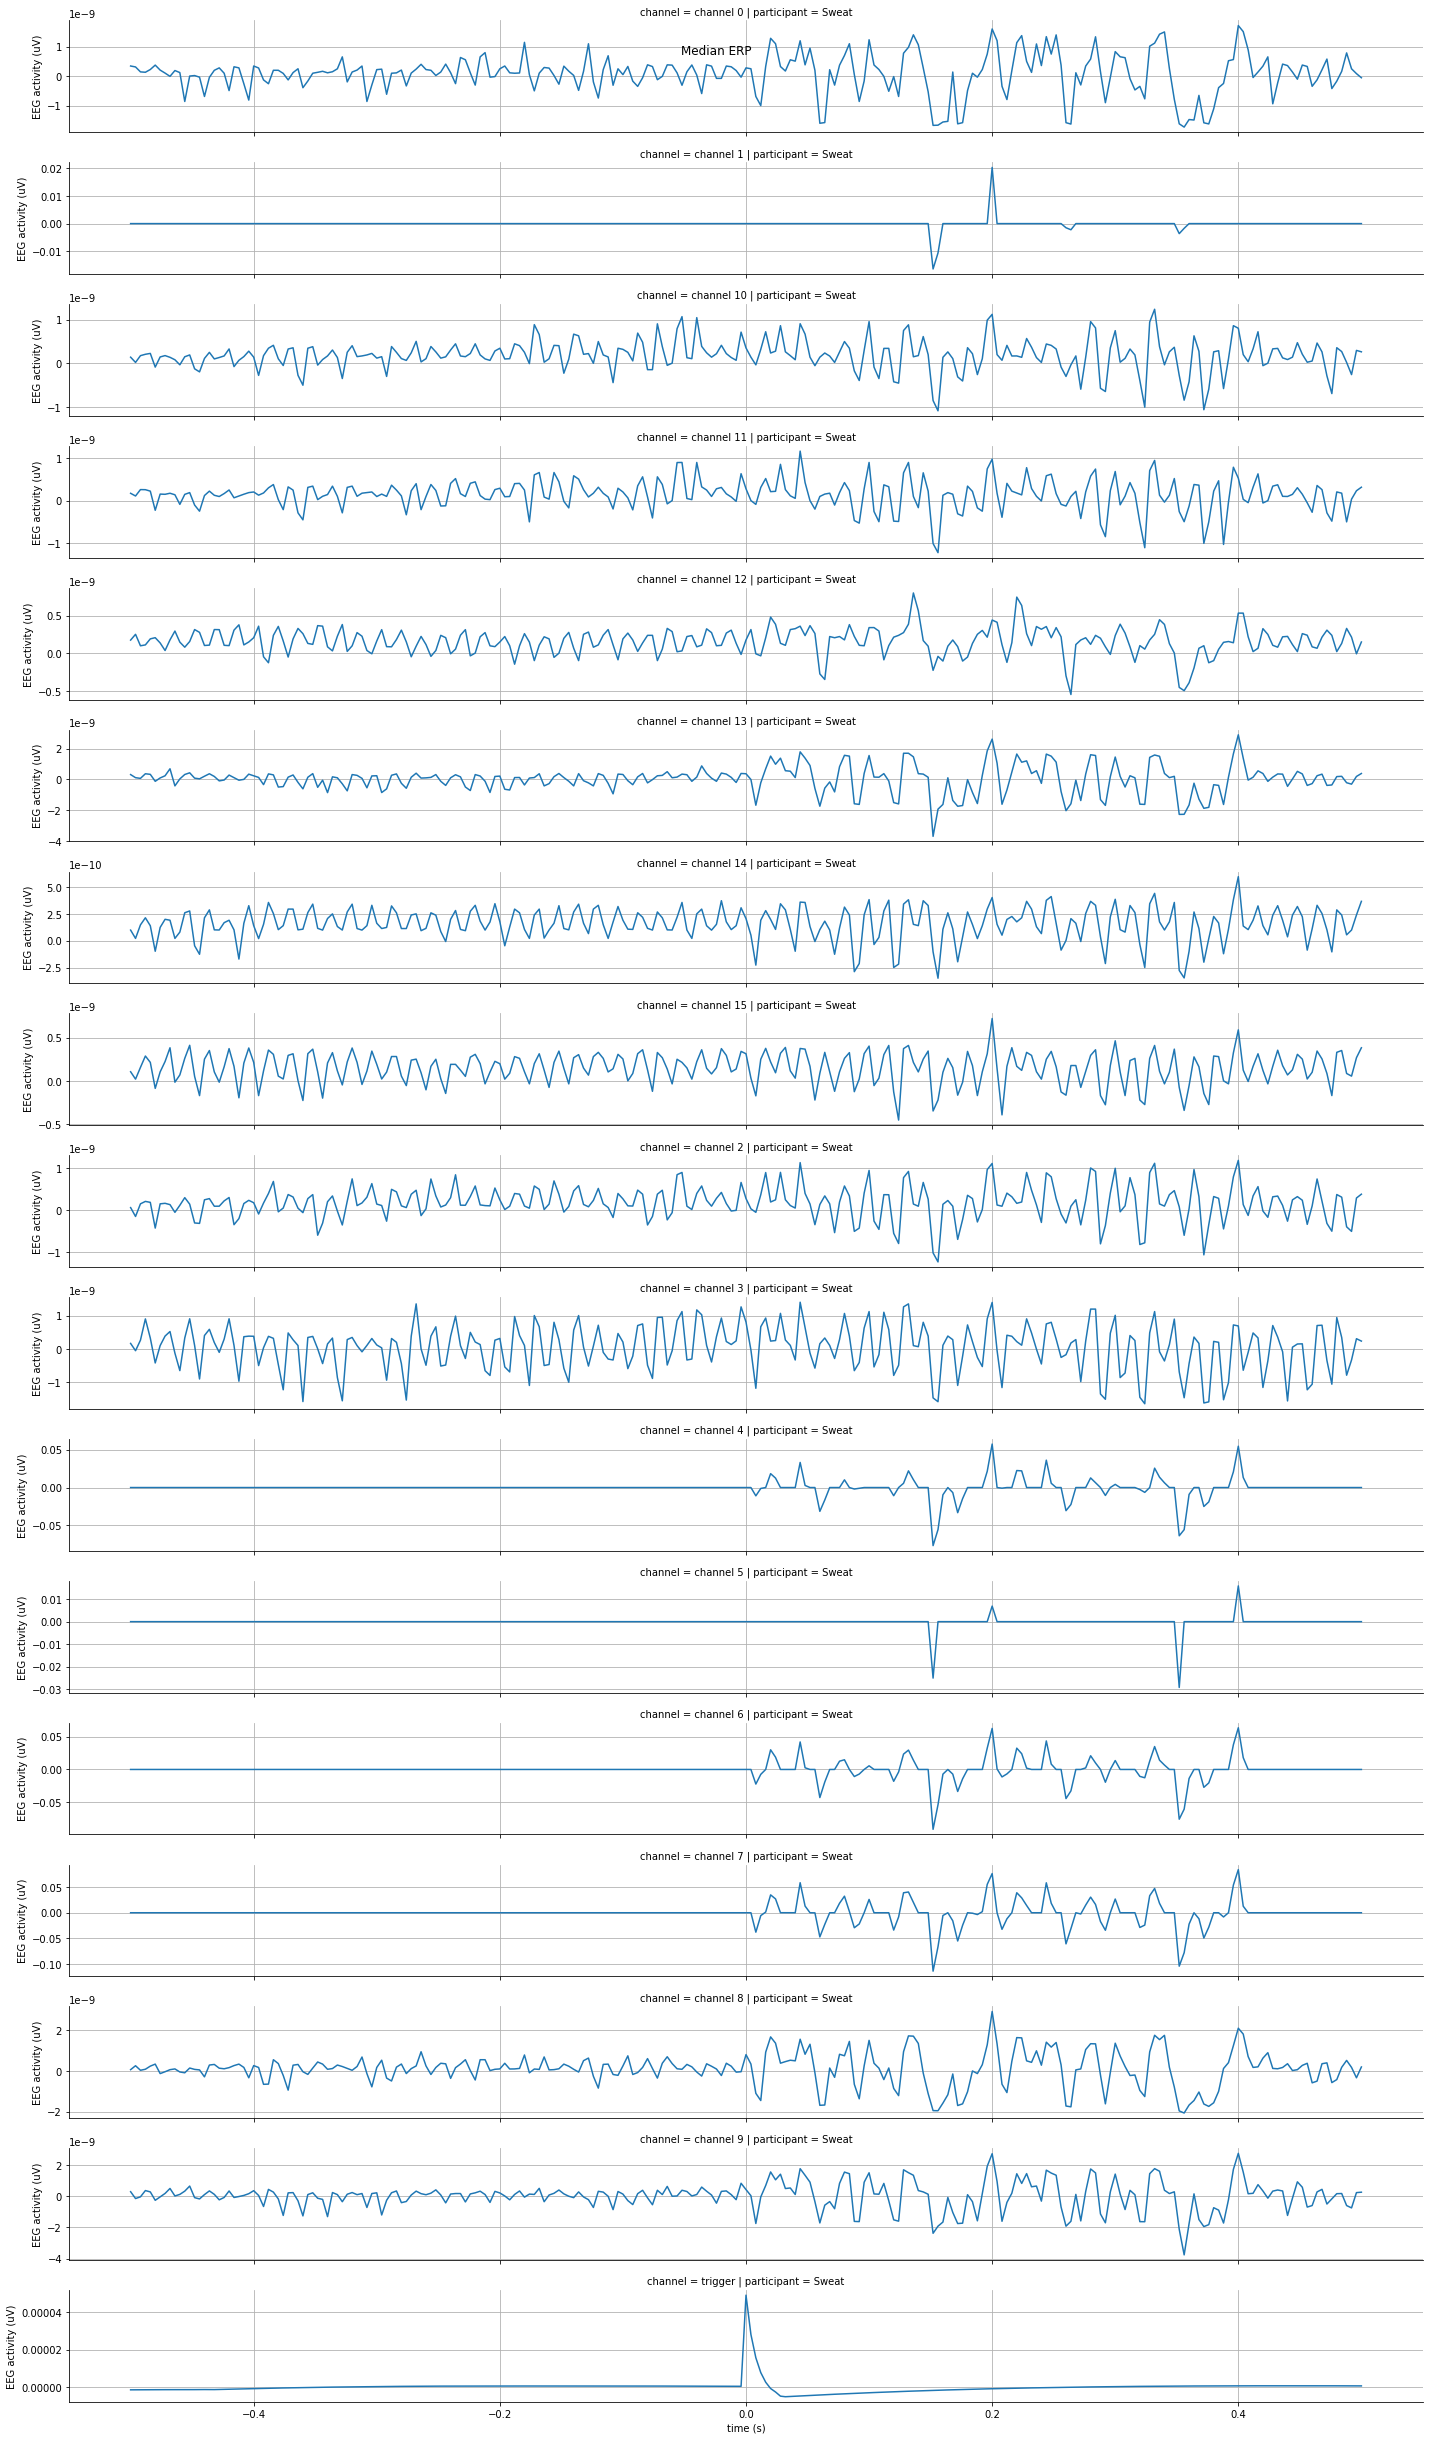

In [158]:
# Resultats avec y-axis non partage
plot_median_ERP(df_ERP, participant='Sweat', height=2, aspect=10, sharey=False)